In [49]:
import torch
import torch.nn as nn
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Loading Data

In [50]:
data = pd.read_csv('./data/lstm_disturbance.csv')
data

,Unnamed: 0,X,Y,Z,VX,VY,VZ,Roll,Pitch,Yaw,Rate Roll,Rate Pitch,Rate Yaw,Wind X,Wind Y,Wind Z,Disturbance X,Disturbance Y,Disturbance Z,Flight Num
0,0,0.000000,0.000000,30.000000,0.000688,0.000423,0.000000,0.000341,0.003703,0.001218,0.000188,0.710143,-0.000518,-0.232247,0.067480,-0.079292,-0.000000,-0.000000,-0.000000,0.0
1,1,0.000008,0.000000,30.000000,-0.000196,-0.001608,0.000007,0.001088,0.013281,0.000740,-0.000353,1.158929,-0.003670,-0.232247,0.067480,-0.079292,-0.013077,0.001096,-0.001554,0.0
2,2,0.000014,-0.000020,30.000000,-0.000578,-0.002173,0.000015,0.002231,0.027328,0.000791,-0.005346,1.426433,-0.004808,-0.232247,0.067480,-0.079292,-0.012895,0.001157,-0.001644,0.0
3,3,0.000023,-0.000040,30.000000,0.004488,-0.001242,0.000070,0.003566,0.041830,-0.000714,-0.011061,1.569898,-0.006780,-0.232247,0.067480,-0.079292,-0.012720,0.001173,-0.001779,0.0
4,4,0.000089,-0.000055,30.000000,0.007375,-0.001586,0.000312,0.003031,0.058209,-0.001571,-0.015686,1.636807,-0.004183,-0.232247,0.067480,-0.079292,-0.013157,0.001126,-0.001926,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474825,1474825,-3.790196,-3.328115,30.025335,0.627202,1.048855,0.202347,0.032815,0.336936,-0.001150,0.006848,0.046823,0.011361,-12.531930,0.018016,-0.203005,-37.069999,-0.346920,-5.019123,181.0
1474826,1474826,-3.783492,-3.317723,30.025497,0.623129,1.047415,0.201535,0.032626,0.335921,-0.001337,0.001863,0.060812,0.007711,-12.530200,0.011620,-0.207065,-37.103578,-0.340958,-4.972342,181.0
1474827,1474827,-3.776835,-3.307345,30.025669,0.620832,1.045838,0.200876,0.032762,0.337555,-0.001172,-0.001975,0.072535,0.009355,-12.531914,0.009740,-0.205671,-37.087646,-0.344521,-4.950997,181.0
1474828,1474828,-3.770196,-3.296983,30.025829,0.616268,1.039851,0.200235,0.032862,0.337143,-0.001107,0.001445,0.079227,0.008201,-12.533954,0.011930,-0.203663,-37.043918,-0.344191,-4.989985,181.0


In [51]:
data = data[::10] # 0.01 -> 0.1 s

First, change X, Y, Z into delta X,Y,Z

In [52]:
data['X'] = data['X'].diff()
data['Y'] = data['Y'].diff()
data['Z'] = data['Z'].diff()
data = data.dropna()

/tmp/ipykernel_2682690/1879319837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['X'] = data['X'].diff()
/tmp/ipykernel_2682690/1879319837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Y'] = data['Y'].diff()
/tmp/ipykernel_2682690/1879319837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Next, subsample the data to only have points every 0.1 seconds (every 10 samples), at the same time build the time sequences and normalize the data.

In [53]:
def normalize_lstm_input(input):
    normalization = np.array([1.5, 1.5, 1.5, 15, 15, 15, np.pi/12, np.pi/12, np.pi/12])

    return input / normalization

In [54]:
grouped = data.groupby('Flight Num')
timestep = 10

sequenced_x = []
sequenced_y = []

for flight_num, flight_df in tqdm(grouped):
    x_data = flight_df[['X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'Roll', 'Pitch', 'Yaw']]
    y_data = flight_df[['Disturbance X', 'Disturbance Y', 'Disturbance Z']]
    
    x_np = x_data.to_numpy()
    y_np = y_data.to_numpy()
    
    for i in range(0, x_np.shape[0]-timestep):
        curr_sequence = []
        for j in range(i, i+timestep):
            curr_sequence.append(normalize_lstm_input(x_np[j]))
            
        sequenced_x.append(curr_sequence)
        sequenced_y.append(y_np[i+timestep-1])

sequenced_y = np.array(sequenced_y)
sequenced_x = np.array(sequenced_x)

100%|██████████| 182/182 [00:03<00:00, 55.08it/s]


In [55]:
print(f'X shape: {sequenced_x.shape}, Y shape: {sequenced_y.shape}')

X shape: (145662, 10, 9), Y shape: (145662, 3)


In [56]:
# Make sure we are predicting the current point, not off by 1 somewhere
assert data.loc[100]['Disturbance X'] == sequenced_y[0][0]

## Training LSTM

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

In [59]:
len(sequenced_x)* 0.9

131095.80000000002

In [60]:
x_dim = sequenced_x[0][0].shape[0]
y_dim = sequenced_y[0].shape[0]

lstm = LSTM(x_dim, 64, 2, y_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-4)

train_points = int(len(sequenced_x)*0.9)

X = torch.tensor(sequenced_x[:train_points], dtype=torch.float32)
y = torch.tensor(sequenced_y[:train_points], dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

losses = []
n_epochs = 10
for i in tqdm(range(n_epochs)):
    for (X, y) in dataloader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = lstm(X)
        loss = criterion(y, preds)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [09:11<00:00, 55.11s/it]


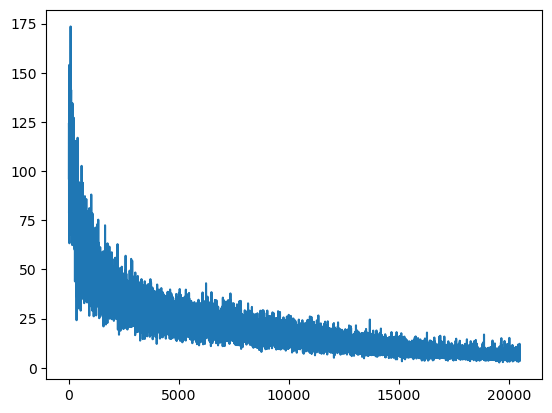

In [61]:
plt.plot(losses)

In [62]:
preds = []
ys = []

for x, y in zip(sequenced_x[train_points:], sequenced_y[train_points:]):
    x = torch.tensor(x, dtype=torch.float32).to(device).unsqueeze(0)
    pred = lstm(x)
    preds.append(pred.detach().cpu().numpy())
    ys.append(y)
    
preds = np.array(preds)
ys = np.array(ys)

In [63]:
preds.shape

(14567, 1, 3)

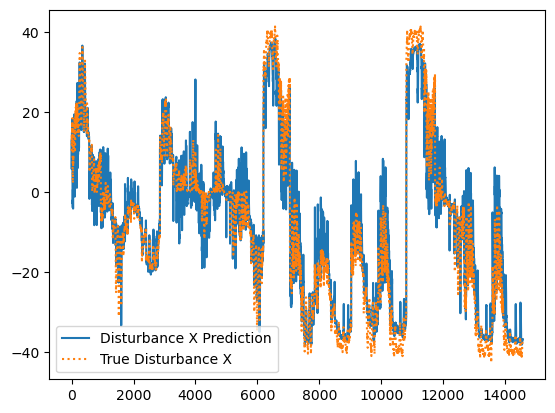

In [66]:
plt.plot(preds.squeeze()[:,0], label='Disturbance X Prediction')
plt.plot(ys[:,0], linestyle=':', label='True Disturbance X')
plt.legend()
# plt.xlim(0,1000)

This seems good enough for the RL agent!

In [65]:
torch.save(lstm.state_dict(), './saved_models/lstm_disturbance.pth')